In [0]:
#Installing the dependencies
#We render images in colab so we need virtual display packages 

!apt-get install libjpeg-dev
!apt-get install -y python-numpy python-dev cmake zlib1g-dev libjpeg-dev xvfb ffmpeg xorg-dev python-opengl libboost-all-dev libsdl2-dev swig
!pip install gym gym[atari]
!pip install stable-baselines
!apt-get install python-opengl -y
!apt install-y xvfb xvfbwrapper
!pip install pyvirtualdisplay piglet
!apt-get update && sudo apt-get install cmake libopenmpi-dev python3-dev zlib1g-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libjpeg-dev is already the newest version (8c-2ubuntu8).
libjpeg-dev set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libjpeg-dev is already the newest version (8c-2ubuntu8).
python-dev is already the newest version (2.7.15~rc1-1).
zlib1g-dev is already the newest version (1:1.2.11.dfsg-0ubuntu2).
zlib1g-dev set to manually installed.
The following additional packages will be installed:
  autotools-dev cmake-data file fontconfig freeglut3 gir1.2-ibus-1.0
  i965-va-driver ibverbs-providers libaacs0 libarchive13 libasound2
  libasound2-data libasound2-dev libass9 libasyncns0 libavc1394-0 libavcodec57
  libavdevice57 libavfilter6 libavformat57 libavresample3 libavutil55
  libbdplus0 libbluray2 libboost-atomic-dev libboost-atomic1.65-dev
  libboost-atomic1.65.1

In [0]:
#import the packages

import os
import gym
from stable_baselines.results_plotter import load_results
from stable_baselines.deepq.policies import  CnnPolicy,MlpPolicy
from stable_baselines import DQN
from stable_baselines.common.vec_env.dummy_vec_env import DummyVecEnv
from stable_baselines.bench import Monitor
import numpy as np
import matplotlib.pyplot as plt

#initialize the virtual display
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [0]:
# Logging method
def make_env():
  #Save the log contents
  log_dir = "/tmp/gym/space"
  os.makedirs(log_dir, exist_ok=True)
  env = gym.make('SpaceInvaders-v0')
  env = Monitor(env, log_dir, allow_early_resets=True)
  env = DummyVecEnv([lambda: env])
  return env

In [0]:
# Evalutation method, used to predict rewards and compute the mean reward for episodes
# Ref: https://stable-baselines.readthedocs.io/en/master/guide/examples.html?highlight=monitor
def evaluate(model,name,num_steps=1000):
  episode_rewards = [0.0]
  obs = env.reset()
  for i in range(num_steps):
      # Q array formed. vectorized env is used, therefore an array is used. 
      action, _states = model.predict(obs)
      obs, rewards, dones, info = env.step(action)
      episode_rewards[-1] += rewards[0]
      if dones[0]:
          obs = env.reset()
          episode_rewards.append(0.0)
  mean_ep_reward = round(np.mean(episode_rewards[-100:]), 1)
  print("Mean reward for ",name," is : ",mean_ep_reward, "Num episodes:", len(episode_rewards))

In [0]:
# Plot results
def plot_graph(result):
  plt.xlabel('Episodes')
  plt.ylabel('Mean Rewards for Episode')
  plt.plot(np.cumsum(result.l),result.r)
  plt.show()

In [0]:
# Create environment
env=make_env()
print(env.action_space)
print(env.observation_space)

/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Discrete(6)
Box(210, 160, 3)


In [0]:
# Init model using CNN policy, since images are fed as inputs. env is passed to the model
model = DQN(CnnPolicy, env, verbose=2)

In [0]:
# Eval the model before the learning
evaluate(model,'SpaceInvaders',num_steps=10000)

Mean reward for  SpaceInvaders  is :  78.6 Num episodes: 11


In [0]:
# The model learns from the dataset
model.learn(total_timesteps=1000,log_interval=100)

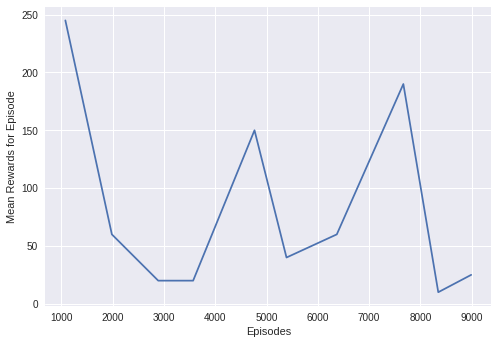

In [0]:
# The results are plotted using the log files
log_dir = "/tmp/gym/space"
result = load_results(log_dir)
plot_graph(result)

In [0]:
# Model is evaluated after learning
evaluate(model,'SpaceInvaders',num_steps=10000)

Mean reward for  SpaceInvaders  is :  56.7 Num episodes: 12


In [0]:
# render the rewards by predicting with the model
mean_rewards=[]
frames=[]
obs = env.reset()
for _ in range(1000):
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)                  
    fig=env.render('rgb_array')
    frames.append(fig)
    if dones[0]:
        env.reset()      
        mean_rewards.append(rewards) 

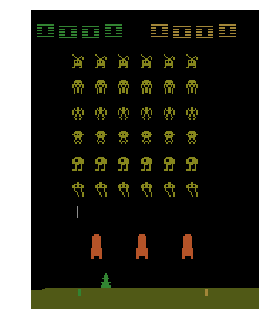

In [0]:
fig, ax = plt.subplots()
plt.axis('off')
l = ax.imshow(frames[112])

In [0]:
# save the model in a video
!apt install ffmpeg
!which ffmpeg
plt.rcParams['animation.ffmpeg_path'] = u'/usr/bin/ffmpeg'

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.4-0ubuntu0.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.
/usr/bin/ffmpeg


In [0]:
from matplotlib import rc, animation
import time
def animate(i):
    l.set_data(frames[i])

Writer = animation.writers['ffmpeg']
writer = Writer(fps=12, metadata=dict(artist='Me'))
ani = animation.FuncAnimation(fig, animate, frames=100)

ani.save('animation.mp4', writer=writer, dpi=220)
time.sleep(5) # let it process (only necessary in Colab)

In [0]:
try:
  from google.colab import files
except:
  print("Could not import Google Colab.")
# To Save Animation
files.download('animation.mp4')